# Composable Overlay Tutorial (sw)

In [1]:
from pynq import Overlay, allocate
import matplotlib.pyplot as plt
import pynq_composable
import numpy as np
import fir

Download the overlay onto the FPGA

In [6]:
ol = Overlay("fir.bit")

Create composable object `cfilter`

In [7]:
cfilter = ol.filter

Explore IP available for composition

In [8]:
cfilter.c_dict

{'fir_stopband': {'ci': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'pi': [5]},
 'axis_data_fifo': {'pi': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'axis_data_fifo',
  'ci': [5]},
 'fir_lowpass': {'ci': [1],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'pi': [3]},
 'fir_highpass': {'ci': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'pi': [4]},
 'fir_bandpass': {'pi': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'ci': [4]},
 'ps_in': {'dfx': False,
  'loaded': True,
  'modtype': 'axi_dma',
  'ci': [3],
  'default': True,
  'fullpath': 'axi_dma'},
 'ps_out': {'pi': [1],
  'dfx': False,
  'loaded': True,
  'modtype': 'axi_dma',
  'default': True,
  'fullpath': 'axi_dma'}}

As displayed above, the design has four FIR that are available.
- Bandpass
- Lowpass
- Highpass
- Stoppass

Filters are designed with a sampling frequency of 44,100 Hz.

## FIR filters Frequency response

The Frequency response of the four filters is shown below

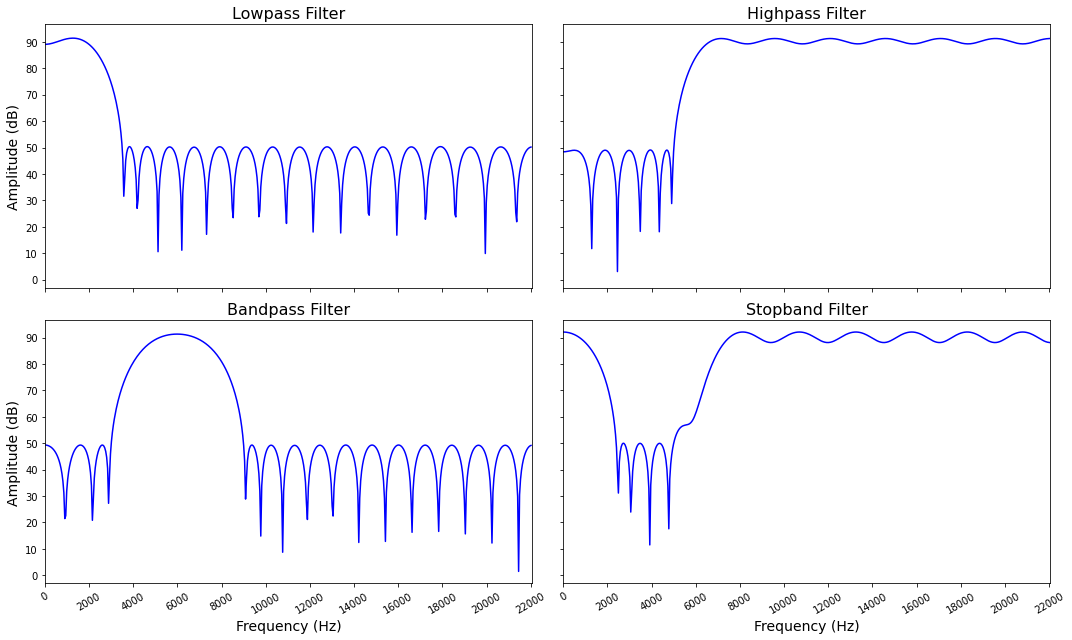

In [9]:
f = fir.Filters()

f.plot()

## Create tones

Let's create sample tones to test the filters

In [2]:
f0, f1, f2, f3 = 1000, 4000, 6000, 8000

In [3]:
samples = 128
fs = 44100
ix = np.arange(samples)
tone_0 = np.int32( 800 * np.sin(2 * np.pi * f0 * ix / fs))
tone_1 = np.int32( 1200 * np.sin(2 * np.pi * f1 * ix / fs))
tone_2 = np.int32( -555 * np.sin(2 * np.pi * f2 * ix / fs))
tone_3 = np.int32( 68 * np.sin(2 * np.pi * f3 * ix / fs))

In [ ]:
plt.figure(figsize=(20, 5));
plt.plot(ix*1000/fs, tone_0, 'o', label = str(f0) + ' Hz');
plt.plot(ix*1000/fs, tone_1, 'o', label = str(f1) + ' Hz');
plt.plot(ix*1000/fs, tone_2, 'o', label = str(f2) + ' Hz');
plt.plot(ix*1000/fs, tone_3, 'o', label = str(f3) + ' Hz');
plt.title("Tones");
plt.xlabel("Time (ms)");
plt.ylabel("Amplitude");
plt.legend();

## Compose

Let's start with a lowpass filter

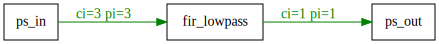

In [12]:
cfilter.compose([cfilter.ps_in, cfilter.fir_lowpass, cfilter.ps_out])

cfilter.graph

In [13]:
dma_send = ol.axi_dma.sendchannel
dma_recv = ol.axi_dma.recvchannel

In [14]:
input_buffer = allocate(shape=(samples,), dtype=np.int32)
output_buffer = allocate(shape=(samples,), dtype=np.int32)
input_buffer[:] = tone_0

In [15]:
dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)

In [ ]:
plt.figure(figsize=(20, 5));
plt.plot(ix*1000/fs, output_buffer, 'o', label = 'Filter');
plt.plot(ix*1000/fs, tone_0, 'o', label = 'Original');
plt.title("Tones");
plt.xlabel("Time (ms)");
plt.ylabel("Amplitude");
plt.legend();

Delay (in number of samples) of a linear-phase FIR is $\frac{(N-1)}{2}$, where N is the number of taps. In our case N is 29, therefore the FIR filters in this desing have a 14 sample delay.


In [ ]:
cfilter.compose([cfilter.ps_in, cfilter.fir_highpass, cfilter.ps_out])
cfilter.graph

In [ ]:
dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)

In [ ]:
plt.figure(figsize=(20, 5));
plt.plot(ix*1000/fs, output_buffer, 'o', label = 'Filter');
plt.plot(ix*1000/fs, tone_0, 'o', label = 'Original');
plt.title("Tones");
plt.xlabel("Time (ms)");
plt.ylabel("Amplitude");
plt.legend();

In [ ]:
input_buffer[:] = tone_3
dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)

In [ ]:
plt.figure(figsize=(20, 5));
plt.plot(ix*1000/fs, output_buffer, 'o', label = 'Filter');
plt.plot(ix*1000/fs, tone_3, 'o', label = 'Original');
plt.title("Tones");
plt.xlabel("Time (ms)");
plt.ylabel("Amplitude");
plt.legend();

## Working with real audio

sudo apt-get install ffmpeg
install `python3 -m pip install audio2numpy`

https://pixabay.com/music/introoutro-clip-02-newsflash-446/

In [105]:
from audio2numpy import open_audio
from IPython.display import Audio
fp = "clip_02_newsflash-446.mp3"
signal, sampling_rate = open_audio(fp)

In [106]:
sampling_rate

44100

In [108]:
signal.shape

(557568, 2)

Transpose the matrix to separate the channels

In [109]:
samples= np.transpose(signal)

Allocate buffers and assign half of the samples to the input buffer

In [130]:
shape = (len(samples[0])//2, )
input_buffer = allocate(shape=shape, dtype=np.int32)
output_buffer = allocate(shape=shape, dtype=np.int32)

input_buffer[:] = np.int32(samples[0][0:len(samples[0])//2] * 100_000)

Generate Audio widget for the samples

In [ ]:
Audio(input_buffer, rate=sampling_rate)

Compose with fifo

In [157]:
cfilter.compose([cfilter.ps_in, cfilter.axis_data_fifo, cfilter.ps_out])

dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

In [ ]:
Audio(output_buffer, rate=sampling_rate)

In [ ]:
np.array_equal(input_buffer, output_buffer)

Compose low pass filter and DMA samples

In [149]:
cfilter.compose([cfilter.ps_in, cfilter.fir_lowpass, cfilter.ps_out])

dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

Generate Audio widget for the outpur signals

In [ ]:
Audio(output_buffer, rate=sampling_rate)

In [151]:
cfilter.compose([cfilter.ps_in, cfilter.fir_highpass, cfilter.ps_out])

dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

Generate Audio widget for the outpur signals

In [ ]:
Audio(output_buffer, rate=sampling_rate)

In [153]:
cfilter.compose([cfilter.ps_in, cfilter.fir_bandpass, cfilter.ps_out])

dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

Generate Audio widget for the outpur signals

In [ ]:
Audio(output_buffer, rate=sampling_rate)

In [155]:
cfilter.compose([cfilter.ps_in, cfilter.fir_stopband, cfilter.ps_out])

dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

Generate Audio widget for the outpur signals

In [ ]:
Audio(output_buffer, rate=sampling_rate)